In [1]:
using CUDA, Colors, ColorMatrixConvention

In [2]:
function generate_kernel(f, img)
    r, c = Int32.(size(img))
    i = threadIdx().x + (blockIdx().x - 1) * blockDim().x
    j = threadIdx().y + (blockIdx().y - 1) * blockDim().y
    
    @inbounds if i <= r && j <= c
        @inline img[i,j] = eltype(img)(f(i,j,r,c))
    end
    return
end

function generate(f, img::CuArray{C}, sync=true) where C<:Colorant
    threads = 16,16
    blocks = cld.(size(img), threads)
        @cuda threads=threads blocks=blocks generate_kernel(f, img)
        if sync
            CUDA.synchronize()
        end
    img
end

generate (generic function with 2 methods)

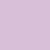

In [3]:
let 
    simple(i,j,r,c) = colorant"thistle"
    
    n = 50
    b = CuArray{RGB{Float32}}(undef, n,n)
    generate(simple, b)
    b
end